In [368]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from collections import Counter
import scipy.sparse as sp 

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns

In [369]:
    df_info = pd.read_csv('data/seinfeld-chronicles/episode_info.csv')
    df_info.head()

,OverallEPNo,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID,Rating
0,0,1,0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,S01E00,NaN
1,1,1,1,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E01,NaN
2,2,1,2,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,S01E02,NaN
3,3,1,3,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E03,NaN
4,4,1,4,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E04,NaN


In [385]:
df_scripts = pd.read_csv('data/seinfeld-chronicles/scripts.csv')
df_scripts.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E00,1.0
2,2,GEORGE,Are you through?,1.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",1.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E00,1.0


In [386]:
df_scripts.EpisodeNo = np.where(df_scripts.SEID =='S01E00', 0.0, df_scripts.EpisodeNo)

In [390]:
df_scripts.EpisodeNo.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [391]:
df_scripts.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0


In [392]:
df_scripts.shape

(54616, 6)

In [393]:
df_scripts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54616 entries, 0 to 54615
Data columns (total 6 columns):
Unnamed: 0    54616 non-null int64
Character     54616 non-null object
Dialogue      54606 non-null object
EpisodeNo     54616 non-null float64
SEID          54616 non-null object
Season        54616 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.5+ MB


In [394]:
df_scripts[df_scripts.isnull().any(axis=1)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
13529,13529,** Pies - Just in case you did not know what t...,NaN,7.0,S04E07,4.0
14938,14938,"[On the bright side, Kramer and George arrive ...",NaN,12.0,S04E12,4.0
18353,18353,(The show begins. There are three different se...,NaN,24.0,S04E24,4.0
18354,18354,(Jerry's doing his stand-up routine at a comed...,NaN,24.0,S04E24,4.0
18355,18355,"We see the title 'Jerry', then, sitting at the...",NaN,24.0,S04E24,4.0
42939,42939,Definitions of several items in the Chicken Ro...,NaN,8.0,S08E08,8.0
45847,45847,HAL,NaN,18.0,S08E18,8.0
49651,49651,Notice,NaN,8.0,S09E08,9.0
50013,50013,The definition of Sari or Saree is,NaN,8.0,S09E08,9.0
53142,53142,MONTAGE,NaN,18.0,S09E18,9.0


In [395]:
df_scripts = df_scripts.dropna()

In [396]:
# How many unique Characters are there in the scripts
df_scripts['Character'].unique().shape

(1631,)

In [397]:
df_scripts['Character'].value_counts()

JERRY                                                                                                                                                     14786
GEORGE                                                                                                                                                     9708
ELAINE                                                                                                                                                     7983
KRAMER                                                                                                                                                     6664
NEWMAN                                                                                                                                                      640
MORTY                                                                                                                                                       505
HELEN                                   

In [398]:
# How many unique Characters are there in the scripts
character_lines = df_scripts['Character'].value_counts()
character_lines = character_lines.reset_index()

In [465]:
df_scripts[(df_scripts['SEID']=='S01E01') & (df_scripts['Season']==1.0)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
211,211,JERRY,"So, Im on line at the supermarket. Two women i...",1.0,S01E01,1.0
212,212,AUDIENCE,Cheque.,1.0,S01E01,1.0
213,213,JERRY,"Cheque. Now, the fact is, if its a woman in fr...",1.0,S01E01,1.0
214,214,JERRY,Whats that one?,1.0,S01E01,1.0
215,215,ELAINE,Coccoon II The Return. I guess they didnt like...,1.0,S01E01,1.0
216,216,JERRY,Maybe they came back for Chinese food. Yknow M...,1.0,S01E01,1.0
217,217,ELAINE,"Okay, whatre we doing here? I have seen everyt...",1.0,S01E01,1.0
218,218,JERRY,Oh yeah? I dont believe youve seen... this.,1.0,S01E01,1.0
219,219,ELAINE,"Oh, lovely.",1.0,S01E01,1.0
220,220,JERRY,Yeah.,1.0,S01E01,1.0


In [463]:
df_scripts[df_scripts['SEID']=='S01E01']

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
211,211,JERRY,"So, Im on line at the supermarket. Two women i...",1.0,S01E01,1.0
212,212,AUDIENCE,Cheque.,1.0,S01E01,1.0
213,213,JERRY,"Cheque. Now, the fact is, if its a woman in fr...",1.0,S01E01,1.0
214,214,JERRY,Whats that one?,1.0,S01E01,1.0
215,215,ELAINE,Coccoon II The Return. I guess they didnt like...,1.0,S01E01,1.0
216,216,JERRY,Maybe they came back for Chinese food. Yknow M...,1.0,S01E01,1.0
217,217,ELAINE,"Okay, whatre we doing here? I have seen everyt...",1.0,S01E01,1.0
218,218,JERRY,Oh yeah? I dont believe youve seen... this.,1.0,S01E01,1.0
219,219,ELAINE,"Oh, lovely.",1.0,S01E01,1.0
220,220,JERRY,Yeah.,1.0,S01E01,1.0


In [408]:
df_scripts[(df_scripts['EpisodeNo']==0.0) & (df_scripts['Season']==1.0)]['Character'].value_counts()

JERRY                                                          94
GEORGE                                                         70
KESSLER                                                        20
LAURA                                                          15
CLAIRE                                                          7
(George shows his note-block to Jerry; it says very largely     1
LAURA & JERRY                                                   1
GEORGE & JERRY                                                  1
KRAMER                                                          1
CLAIE                                                           1
Name: Character, dtype: int64

In [409]:
df_scripts[(df_scripts['EpisodeNo']==0.0) & (df_scripts['Season']==1.0) & (df_scripts['Character']=="LAURA & JERRY")]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
173,173,LAURA & JERRY,Heeeey!,0.0,S01E00,1.0


In [410]:
# How many Character lines contain a parenthesis?
df_scripts[df_scripts['Character'].str.contains('(',regex=False)].count()

Unnamed: 0    583
Character     583
Dialogue      583
EpisodeNo     583
SEID          583
Season        583
dtype: int64

In [411]:
import string
string.punctuation
punct = '''[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'''

In [412]:
# How many Character lines contain Punctuation?
df_scripts[df_scripts['Character'].str.contains(punct)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
52,52,(George shows his note-block to Jerry; it says...,NO.),0.0,S01E00,1.0
173,173,LAURA & JERRY,Heeeey!,0.0,S01E00,1.0
182,182,GEORGE & JERRY,"Ooh yeah, the bags, sure.",0.0,S01E00,1.0
262,262,"GUESTS, JERRY & ELAINE",Hi,1.0,S01E01,1.0
349,349,HELEN & MORTY,"Oh, well...",1.0,S01E01,1.0
435,435,JERRY & George,(turning to each other) I dont know. Hes an im...,1.0,S01E01,1.0
833,833,MAN #1,"I get a call from Gilmour this morning, and ge...",2.0,S01E02,1.0
834,834,MAN #2,Really? What are you gonna bout the apartment?,2.0,S01E02,1.0
835,835,MAN #1,"Well, what can I do? Give it up.",2.0,S01E02,1.0
836,836,"JERRY, GEORGE & ELAINE",Whats the rent?,2.0,S01E02,1.0


In [413]:
# How many Dialogue lines contain Punctuation? (almost ALL of them)
df_scripts[df_scripts['Dialogue'].str.contains(punct)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
5,5,JERRY,"Oh, you dont recall?",0.0,S01E00,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",0.0,S01E00,1.0
7,7,JERRY,"Well, senator, Id just like to know, what you ...",0.0,S01E00,1.0
8,8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,0.0,S01E00,1.0
9,9,GEORGE,"Are, are you sure this is decaf? Wheres the or...",0.0,S01E00,1.0


In [414]:
df_scripts[df_scripts['Dialogue'].str.contains('(', regex=False)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",0.0,S01E00,1.0
20,20,JERRY,"(looks in the creamer) Theres no milk in here,...",0.0,S01E00,1.0
21,21,GEORGE,"Wait wait wait, what is she... (takes the milk...",0.0,S01E00,1.0
23,23,GEORGE,"(smiling) So, you know, what, what happened?",0.0,S01E00,1.0
31,31,GEORGE,"(whistles disapprovingly) Ho ho ho, Had to? Ha...",0.0,S01E00,1.0
46,46,GEORGE,"(to Claire) Now, a woman calls me, all right?",0.0,S01E00,1.0
55,55,JERRY,"Good. Did you have fun? You have no idea, what...",0.0,S01E00,1.0
59,59,CLAIRE,"(to Jerry) Dont worry, I gave him a little caf...",0.0,S01E00,1.0


In [415]:
### Calculate Lines per Season
main_characters = ['Jerry', 'GEORGE', 'ELAINE', 'KRAMER', 'NEWMAN']

In [416]:
def strip_formatting(string):
    string = string.lower().rstrip().lstrip()
    string = re.sub(r"([.!?,'/()])", r"", string)
    return string

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_lines(lines):
    lines = [REPLACE_NO_SPACE.sub("", line.lower()) for line in lines]
    lines = [REPLACE_WITH_SPACE.sub(" ", line) for line in lines]
    
    return lines

def get_actions(line):
    regex = re.compile(".*?\((.*?)\)")
    actions = re.findall(regex, line)
    return actions

def remove_actions(line):
    line = re.sub("[\(\[].*?[\)\]]", "", line)
    return line

In [417]:
example = "(Exiting the bedroom with Newman) Let's talk i..."
stripped = strip_formatting(example)
print(stripped)
stripped_2 = preprocess_lines(example)
print(stripped_2)

exiting the bedroom with newman lets talk i
['', 'e', 'x', 'i', 't', 'i', 'n', 'g', ' ', 't', 'h', 'e', ' ', 'b', 'e', 'd', 'r', 'o', 'o', 'm', ' ', 'w', 'i', 't', 'h', ' ', 'n', 'e', 'w', 'm', 'a', 'n', '', ' ', 'l', 'e', 't', '', 's', ' ', 't', 'a', 'l', 'k', ' ', 'i', '', '', '']


In [467]:
# Get all lines spoken by Jerry in season 1, episode 1.
df_jerry_s01_ep01 = df_scripts[(df_scripts['EpisodeNo']==1.0) & \
                               (df_scripts['Season']==1.0) & \
                               (df_scripts['Character']=='JERRY')].copy().reset_index(drop=True)
df_jerry_s01_ep01

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,211,JERRY,"So, Im on line at the supermarket. Two women i...",1.0,S01E01,1.0
1,213,JERRY,"Cheque. Now, the fact is, if its a woman in fr...",1.0,S01E01,1.0
2,214,JERRY,Whats that one?,1.0,S01E01,1.0
3,216,JERRY,Maybe they came back for Chinese food. Yknow M...,1.0,S01E01,1.0
4,218,JERRY,Oh yeah? I dont believe youve seen... this.,1.0,S01E01,1.0
5,220,JERRY,Yeah.,1.0,S01E01,1.0
6,222,JERRY,"So, uh, whats your son doing now, Dr. Stevens?...",1.0,S01E01,1.0
7,224,JERRY,Pamela? Do I know her?,1.0,S01E01,1.0
8,226,JERRY,"Oh yeah, right...",1.0,S01E01,1.0
9,228,JERRY,(quickly) No.,1.0,S01E01,1.0


In [432]:
df_jerry_s01_ep01['Dialogue'][0]

'So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...'

In [469]:
df_jerry_s01_ep00 = df_scripts[(df_scripts['EpisodeNo']==0.0) & \
                               (df_scripts['Season']==1.0) & \
                               (df_scripts['Character']=='JERRY')].copy().reset_index(drop=True)
jerry_s01_ep00_corpus = df_jerry_s01_ep00['Dialogue'].to_list()
jerry_s01_ep00_corpus

['Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.',
 '(pointing at George

In [433]:
jerry_s01_ep01_corpus = df_jerry_s01_ep01['Dialogue'].to_list()
jerry_s01_ep01_corpus

['So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...',
 'Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money but I ha

In [434]:
jerry_s01_ep01_corpus_a_r = [remove_actions(x) for x in jerry_s01_ep01_corpus]
jerry_s01_ep01_corpus_a_r

['So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...',
 'Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster  Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money but I have these. I wrote on these. Is this of any v

In [435]:
# get all actions from this text
jerry_s01_ep01_corpus_actions = [get_actions(x) for x in jerry_s01_ep01_corpus if len(get_actions(x)) > 0]
# flatten this list
jerry_s01_ep01_corpus_actions = [item for sublist in jerry_s01_ep01_corpus_actions for item in sublist]
jerry_s01_ep01_corpus_actions

['Jerry draws imaginary book from a holster.',
 'quickly',
 'a lightbulb goes on in his head',
 'turns to rest of table',
 'thinking',
 'Vanessa smiles; thinking',
 'thinking',
 'turning to Elaine; thinking',
 'tries turning away in the hopes Elaine gets the hint; thinking',
 'thinking',
 'thinking',
 'tries to turn away again; thinking',
 'thinking',
 'turns to talk to Vanessa; to Vanessa',
 'thinking',
 'to Vanessa',
 'thinking; quickly',
 'thinking',
 'pause',
 'The elevator door opens.',
 'reaches for her name',
 'walking in front of George so he gets the picture to leave',
 'annoyed',
 'to Morty',
 'to Helen',
 'introducing himself',
 'sarcastically',
 'pause']

In [436]:
jerry_s01_ep01_corpus_a_r_clean = [strip_formatting(x) for x in jerry_s01_ep01_corpus_a_r]
jerry_s01_ep01_corpus_a_r_clean 

['so im on line at the supermarket two women in front of me one of them her total was eight dollars the other three dollars they both of course choose to pay by the use of the',
 'cheque now the fact is if its a woman in front of you thats writing the cheque you will not be waiting long i have noticed that women are very fast with cheques yknow cause they write out so many cheques the keys they can never find in their purse they dont know where that is but the cheque book they got that they never fumble for the cheque book the cheque book comes out of a holster  who do i make it out to theres my id theres something about a cheque that to a man is not masculine i dont know exactly what it is i think to a man a cheque is like a note from your mother that says i dont have any money but if youll contact these people im sure theyll stick up for me if you just trust me this one time- i dont have any money but i have these i wrote on these is this of any value at all',
 'whats that one',
 'ma

In [437]:
jerry_s01_ep01_corpus_a_r_clean = preprocess_lines(jerry_s01_ep01_corpus_a_r)
jerry_s01_ep01_corpus_a_r_clean 

['so im on line at the supermarket two women in front of me one of them her total was eight dollars the other three dollars they both of course choose to pay by the use of the',
 'cheque now the fact is if its a woman in front of you thats writing the cheque you will not be waiting long i have noticed that women are very fast with cheques yknow cause they write out so many cheques the keys they can never find in their purse they dont know where that is but the cheque book they got that they never fumble for the cheque book the cheque book comes out of a holster  who do i make it out to theres my id theres something about a cheque that to a man is not masculine i dont know exactly what it is i think to a man a cheque is like a note from your mother that says i dont have any money but if youll contact these people im sure theyll stick up for me if you just trust me this one time  i dont have any money but i have these i wrote on these is this of any value at all',
 'whats that one',
 'ma

In [438]:
jerry_s01_ep01_corpus

['So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...',
 'Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money but I ha

In [439]:
print(stop_words)

frozenset({'down', 'onto', 'where', 'seeming', 'system', 'everywhere', 'more', 'show', 'former', 'or', 'no', 'around', 'while', 'whatever', 'wherever', 'enough', 'whereafter', 'could', 'then', 'go', 'became', 'first', 'from', 'only', 'indeed', 'were', 'again', 'ten', 'others', 'couldnt', 'ie', 'into', 'the', 'much', 'due', 'find', 'nobody', 'thereby', 'but', 'about', 'along', 'something', 'had', 'their', 'somehow', 'whose', 'fifteen', 'un', 'am', 'with', 'very', 'forty', 'serious', 'namely', 'towards', 'each', 'five', 'whereas', 'may', 'until', 'some', 'empty', 'therein', 'still', 'perhaps', 'call', 'hence', 'everyone', 'all', 'have', 'because', 'has', 'latterly', 'however', 'up', 'anyway', 'becomes', 'than', 'yours', 'we', 'often', 'us', 'must', 'six', 'whereby', 'what', 'twenty', 'i', 'own', 'hereafter', 'somewhere', 'interest', 'will', 'me', 'fifty', 'which', 'might', 'whole', 'across', 'those', 'everything', 'few', 'when', 'con', 'whom', 'myself', 'thence', 'fill', 'they', 'before'

In [470]:
# Tokenize and get count Vectorizer usking sklearn
stop_words = text.ENGLISH_STOP_WORDS
count = CountVectorizer(stop_words=stop_words) #, max_features=3000, max_df = 1,  min_df=1)
tf = count.fit_transform(jerry_s01_ep00_corpus)
tf = sp.csr_matrix.toarray(tf)
tf
print(len(count.get_feature_names()))
tokens_CV = count.get_feature_names()
print(tokens_CV)

472
['absolutely', 'admit', 'ahead', 'amazing', 'answering', 'anybody', 'apart', 'area', 'areas', 'article', 'articles', 'aside', 'ask', 'avoided', 'awkward', 'babe', 'bad', 'bag', 'baggy', 'bags', 'ball', 'balls', 'basket', 'bathroom', 'beautiful', 'beauty', 'beings', 'believe', 'best', 'better', 'big', 'biggest', 'bit', 'bloodstains', 'boring', 'boss', 'bought', 'bout', 'box', 'bread', 'break', 'breaks', 'bright', 'bubbles', 'building', 'button', 'buttons', 'buy', 'bye', 'called', 'car', 'cash', 'cause', 'cereal', 'certainly', 'chance', 'chest', 'cigarette', 'claire', 'clean', 'close', 'clothes', 'clothing', 'clues', 'cmon', 'cockroaches', 'coffee', 'come', 'comes', 'comin', 'construction', 'contact', 'conversation', 'cotton', 'couch', 'course', 'cover', 'creamer', 'cup', 'cycle', 'cynical', 'dancing', 'dark', 'date', 'dating', 'day', 'days', 'dead', 'death', 'decent', 'definitely', 'detective', 'detergent', 'detergents', 'did', 'didnt', 'die', 'difference', 'does', 'doin', 'doing', 

In [441]:
# tokenize Jerry's Dialogue from Episode 1
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", "..."]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
dialogue = word_tokenize(' '.join(jerry_s01_ep01_corpus))
nopunc = [word.lower() for word in dialogue if word not in stop_words]
nopunc = ' '.join(nopunc)
tokens = [word for word in nopunc.split()]
print(len(set(tokens)))
print(sorted(set(tokens)))

446
['able', 'absolutely', 'admit', 'afraid', 'ah', 'aliens', 'all', 'and', 'anderson', 'annoyed', 'anybody', 'anyway', 'apparently', 'appreciate', 'architect', 'architecture', 'art', 'artie', 'artisan', 'ask', 'away', 'bad', 'bears', 'because', 'bed', 'believe', 'benes', 'bennet', 'bert', 'bet', 'better', 'big', 'birthday', 'book', 'bouillabaisse', 'boy', 'boyfriend', 'bring', 'brutal', 'building', 'bulls', 'business', 'cab', 'called', 'callin', 'came', 'can', 'car', 'card', 'care', 'cause', 'challenge', 'challenging', 'cheating', 'chemistry', 'cheque', 'cheques', 'chilly', 'chinese', 'choose', 'cmon', 'come', 'comedian', 'comes', 'comin', 'coming', 'complicated', 'concept', 'conneticut', 'contact', 'cor', 'corvelay', 'cougar', 'could', 'course', 'cousin', 'craftsman', 'craving', 'crouch', 'dad', 'date', 'deal', 'described', 'dictionary', 'did', 'didnt', 'difference', 'difficult', 'do', 'does', 'doesnt', 'doin', 'doing', 'dollars', 'dont', 'door', 'dr.', 'draws', 'dream', 'drive', 'du

In [442]:
for word in sorted(set(tokens)):
    if word not in tokens_CV:
        print(word)

all
and
anyway
because
can
could
do
dr.
explain-
get
gon
he
how
i
if
importer/exporter
is
it
its
lem
my
na
never
no
now
of
on
one
one-sided
please
she
so
still
ta
that
the
them-
there
they
this
time-
two
uh-huh
uh-oh
was
we
well
were
what
when
where
who
why
would
you


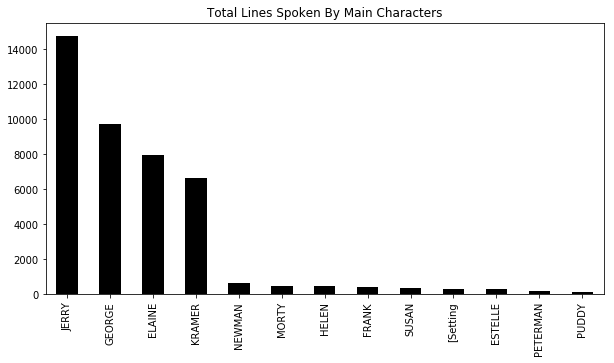

In [443]:
# Total Lines spoken by Character
df_scripts["Character"].value_counts().head(13).plot(kind="bar", 
                                                     figsize=(10,5),
                                                     title="Total Lines Spoken By Main Characters", 
                                                     colormap='gist_stern')

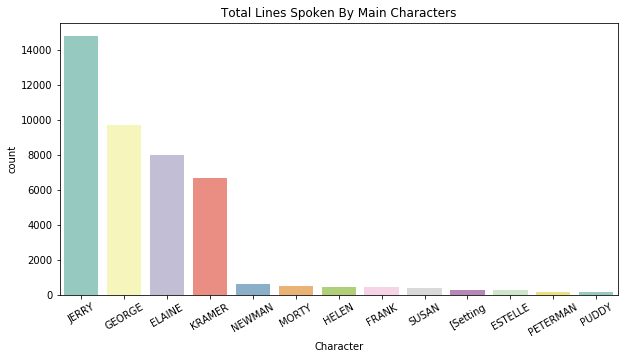

In [444]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x="Character", 
                   data=df_scripts, 
                   order=pd.value_counts(df_scripts['Character']).iloc[:13].index,
                   palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title("Total Lines Spoken By Main Characters");

In [445]:
df_scripts.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0


In [446]:
# jerry_s01_ep01_corpus = df_jerry_s01_ep01['Dialogue'].to_list()

def agg_dialogue_by_episode(df):
    all_documents = []
    df_cols = ['Dialogue', 'Lines_of_Dialogue', 'SEID', 'Season', 'Episode']
    df_new = pd.DataFrame(columns = df_cols)
    
    index = 0
    for SEID in df['SEID'].unique():
        dialogue = df[df['SEID']==SEID]['Dialogue'].to_list()
        lines_of_dialogue = df[df['SEID']==SEID]['EpisodeNo'].count()
        season = df[df['SEID']==SEID]['Season'].unique()[0]
        episode = df[df['SEID']==SEID]['EpisodeNo'].unique()[0]
        
        df_new.loc[index] = [dialogue, lines_of_dialogue, SEID, season, episode]
        
        index += 1
        
    return df_new

In [447]:
df_scripts[df_scripts['Season']==1.0]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
5,5,JERRY,"Oh, you dont recall?",0.0,S01E00,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",0.0,S01E00,1.0
7,7,JERRY,"Well, senator, Id just like to know, what you ...",0.0,S01E00,1.0
8,8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,0.0,S01E00,1.0
9,9,GEORGE,"Are, are you sure this is decaf? Wheres the or...",0.0,S01E00,1.0


In [448]:
df_scripts['SEID'].unique().shape

(174,)

In [450]:
df_docs_by_ep = agg_dialogue_by_episode(df_scripts)

['Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.',
 '(pointing at George

In [451]:
df_docs_by_ep.Dialogue[0]

['Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.',
 '(pointing at George

In [459]:
merged = pd.merge(df_docs_by_ep, df_info.iloc[:,3:], on=['SEID'], suffixes=['_ep', '_info'])

In [458]:
merged

,Dialogue,Lines_of_Dialogue,SEID,Season,Episode,Title,AirDate,Writers,Director,Rating
0,[Do you know what this is all about? Do you kn...,211,S01E00,1.0,0.0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,NaN
1,"[So, Im on line at the supermarket. Two women ...",346,S01E01,1.0,1.0,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
2,"[So I move into the centre lane, now I get ahe...",280,S01E02,1.0,2.0,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,NaN
3,"[Most men like working on things. Tools, objec...",241,S01E03,1.0,3.0,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
4,[Went out to dinner the other night. Check cam...,230,S01E04,1.0,4.0,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
5,[Im always in traffic with the lane expert. Yo...,245,S02E01,2.0,1.0,The Ex-Girlfriend,16-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
6,[My parents live in Florida now. They moved th...,250,S02E02,2.0,2.0,The Pony Remark,30-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
7,"[I hate clothes, okay? I hate buying them. I h...",261,S02E03,2.0,3.0,The Jacket,6-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
8,[The bad thing about television is that everyb...,264,S02E04,2.0,4.0,The Phone Message,13-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
9,"[Well, I painted my apartment again. Ive been ...",281,S02E05,2.0,5.0,The Apartment,4-Apr-91,Peter Mehlman,Tom Cherones,NaN
